In [21]:
firstRecipe = {"ingredients": [{"text": "6 ounces penne"}, {"text": "2 cups Beechers Flagship Cheese Sauce (recipe follows)"}, {"text": "1 ounce Cheddar, grated (1/4 cup)"}, {"text": "1 ounce Gruyere cheese, grated (1/4 cup)"}, {"text": "1/4 to 1/2 teaspoon chipotle chili powder (see Note)"}, {"text": "1/4 cup (1/2 stick) unsalted butter"}, {"text": "1/3 cup all-purpose flour"}, {"text": "3 cups milk"}, {"text": "14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)"}, {"text": "2 ounces semisoft cheese (page 23), grated (1/2 cup)"}, {"text": "1/2 teaspoon kosher salt"}, {"text": "1/4 to 1/2 teaspoon chipotle chili powder"}, {"text": "1/8 teaspoon garlic powder"}, {"text": "(makes about 4 cups)"}], "url": "http://www.epicurious.com/recipes/food/views/-world-s-best-mac-and-cheese-387747", "partition": "train", "title": "Worlds Best Mac and Cheese", "id": "000018c8a5", "instructions": [{"text": "Preheat the oven to 350 F."}, {"text": "Cook the penne 2 minutes less than package directions."}, {"text": "(It will finish cooking in the oven.)"}, {"text": "Rinse the pasta in cold water and set aside."}, {"text": "Combine the cooked pasta and the sauce in a medium bowl and mix carefully but thoroughly."}, {"text": "Scrape the pasta into the prepared baking dish."}, {"text": "Sprinkle the top with the cheeses and then the chili powder."}, {"text": "Bake, uncovered, for 20 minutes."}, {"text": "Let the mac and cheese sit for 5 minutes before serving."}, {"text": "Melt the butter in a heavy-bottomed saucepan over medium heat and whisk in the flour."}, {"text": "Continue whisking and cooking for 2 minutes."}, {"text": "Slowly add the milk, whisking constantly."}, {"text": "Cook until the sauce thickens, about 10 minutes, stirring frequently."}, {"text": "Remove from the heat."}, {"text": "Add the cheeses, salt, chili powder, and garlic powder."}, {"text": "Stir until the cheese is melted and all ingredients are incorporated, about 3 minutes."}, {"text": "Use immediately, or refrigerate for up to 3 days."}, {"text": "This sauce reheats nicely on the stove in a saucepan over low heat."}, {"text": "Stir frequently so the sauce doesnt scorch."}, {"text": "This recipe can be assembled before baking and frozen for up to 3 monthsjust be sure to use a freezer-to-oven pan and increase the baking time to 50 minutes."}, {"text": "One-half teaspoon of chipotle chili powder makes a spicy mac, so make sure your family and friends can handle it!"}, {"text": "The proportion of pasta to cheese sauce is crucial to the success of the dish."}, {"text": "It will look like a lot of sauce for the pasta, but some of the liquid will be absorbed."}]}
print(firstRecipe["instructions"])

[{'text': 'Preheat the oven to 350 F.'}, {'text': 'Cook the penne 2 minutes less than package directions.'}, {'text': '(It will finish cooking in the oven.)'}, {'text': 'Rinse the pasta in cold water and set aside.'}, {'text': 'Combine the cooked pasta and the sauce in a medium bowl and mix carefully but thoroughly.'}, {'text': 'Scrape the pasta into the prepared baking dish.'}, {'text': 'Sprinkle the top with the cheeses and then the chili powder.'}, {'text': 'Bake, uncovered, for 20 minutes.'}, {'text': 'Let the mac and cheese sit for 5 minutes before serving.'}, {'text': 'Melt the butter in a heavy-bottomed saucepan over medium heat and whisk in the flour.'}, {'text': 'Continue whisking and cooking for 2 minutes.'}, {'text': 'Slowly add the milk, whisking constantly.'}, {'text': 'Cook until the sauce thickens, about 10 minutes, stirring frequently.'}, {'text': 'Remove from the heat.'}, {'text': 'Add the cheeses, salt, chili powder, and garlic powder.'}, {'text': 'Stir until the chee

In [83]:
from nltk.stem.wordnet import WordNetLemmatizer
from spacy.lang.en import English

SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "dative", "attr", "oprd", "pobj"]
ADJECTIVES = ["acomp", "advcl", "advmod", "amod", "appos", "nn", "nmod", "ccomp", "complm",
              "hmod", "infmod", "xcomp", "rcmod", "poss"," possessive", "nummod"]
COMPOUNDS = ["compound"]
PREPOSITIONS = ["prep"]

def getSubsFromConjunctions(subs):
    moreSubs = []
    for sub in subs:
        # rights is a generator
        rights = list(sub.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if "and" in rightDeps:
            moreSubs.extend([tok for tok in rights if tok.dep_ in SUBJECTS or tok.pos_ == "NOUN"])
            if len(moreSubs) > 0:
                moreSubs.extend(getSubsFromConjunctions(moreSubs))
    return moreSubs

def getObjsFromConjunctions(objs):
    moreObjs = []
    for obj in objs:
        # rights is a generator
        rights = list(obj.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if "and" in rightDeps:
            moreObjs.extend([tok for tok in rights if tok.dep_ in OBJECTS or tok.pos_ == "NOUN"])
            if len(moreObjs) > 0:
                moreObjs.extend(getObjsFromConjunctions(moreObjs))
    return moreObjs

def getVerbsFromConjunctions(verbs):
    moreVerbs = []
    for verb in verbs:
        rightDeps = {tok.lower_ for tok in verb.rights}
        if "and" in rightDeps:
            moreVerbs.extend([tok for tok in verb.rights if tok.pos_ == "VERB"])
            if len(moreVerbs) > 0:
                moreVerbs.extend(getVerbsFromConjunctions(moreVerbs))
    return moreVerbs

def findSubs(tok):
    head = tok.head
    while head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head:
        head = head.head
    if head.pos_ == "VERB":
        subs = [tok for tok in head.lefts if tok.dep_ == "SUB"]
        if len(subs) > 0:
            verbNegated = isNegated(head)
            subs.extend(getSubsFromConjunctions(subs))
            return subs, verbNegated
        elif head.head != head:
            return findSubs(head)
    elif head.pos_ == "NOUN":
        return [head], isNegated(tok)
    return [], False

def isNegated(tok):
    negations = {"no", "not", "n't", "never", "none"}
    for dep in list(tok.lefts) + list(tok.rights):
        if dep.lower_ in negations:
            return True
    return False

def findSVs(tokens):
    svs = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB"]
    for v in verbs:
        subs, verbNegated = getAllSubs(v)
        if len(subs) > 0:
            for sub in subs:
                svs.append((sub.orth_, "!" + v.orth_ if verbNegated else v.orth_))
    return svs

def getObjsFromPrepositions(deps):
    objs = []
    for dep in deps:
        if dep.pos_ == "ADP" and dep.dep_ == "prep":
            objs.extend([tok for tok in dep.rights if tok.dep_  in OBJECTS or (tok.pos_ == "PRON" and tok.lower_ == "me")])
    return objs

def getAdjectives(toks):
    toks_with_adjectives = []
    for tok in toks:
        adjs = [left for left in tok.lefts if left.dep_ in ADJECTIVES]
        adjs.append(tok)
        adjs.extend([right for right in tok.rights if tok.dep_ in ADJECTIVES])
        tok_with_adj = " ".join([adj.lower_ for adj in adjs])
        toks_with_adjectives.extend(adjs)

    return toks_with_adjectives

def getObjsFromAttrs(deps):
    for dep in deps:
        if dep.pos_ == "NOUN" and dep.dep_ == "attr":
            verbs = [tok for tok in dep.rights if tok.pos_ == "VERB"]
            if len(verbs) > 0:
                for v in verbs:
                    rights = list(v.rights)
                    objs = [tok for tok in rights if tok.dep_ in OBJECTS]
                    objs.extend(getObjsFromPrepositions(rights))
                    if len(objs) > 0:
                        return v, objs
    return None, None

def getObjFromXComp(deps):
    for dep in deps:
        if dep.pos_ == "VERB" and dep.dep_ == "xcomp":
            v = dep
            rights = list(v.rights)
            objs = [tok for tok in rights if tok.dep_ in OBJECTS]
            objs.extend(getObjsFromPrepositions(rights))
            if len(objs) > 0:
                return v, objs
    return None, None

def getAllSubs(v):
    verbNegated = isNegated(v)
    subs = [tok for tok in v.lefts if tok.dep_ in SUBJECTS and tok.pos_ != "DET"]
    if len(subs) > 0:
        subs.extend(getSubsFromConjunctions(subs))
    else:
        foundSubs, verbNegated = findSubs(v)
        subs.extend(foundSubs)
    return subs, verbNegated

def getAllObjs(v):
    # rights is a generator
    rights = list(v.rights)
    objs = [tok for tok in rights if tok.dep_ in OBJECTS]
    objs.extend(getObjsFromPrepositions(rights))

    potentialNewVerb, potentialNewObjs = getObjFromXComp(rights)
    if potentialNewVerb is not None and potentialNewObjs is not None and len(potentialNewObjs) > 0:
        objs.extend(potentialNewObjs)
        v = potentialNewVerb
    if len(objs) > 0:
        objs.extend(getObjsFromConjunctions(objs))
    return v, objs

def getAllObjsWithAdjectives(v):
    # rights is a generator
    rights = list(v.rights)
    objs = [tok for tok in rights if tok.dep_ in OBJECTS]

    if len(objs)== 0:
        objs = [tok for tok in rights if tok.dep_ in ADJECTIVES]

    objs.extend(getObjsFromPrepositions(rights))

    potentialNewVerb, potentialNewObjs = getObjFromXComp(rights)
    if potentialNewVerb is not None and potentialNewObjs is not None and len(potentialNewObjs) > 0:
        objs.extend(potentialNewObjs)
        v = potentialNewVerb
    if len(objs) > 0:
        objs.extend(getObjsFromConjunctions(objs))
    return v, objs

def findSVOs(tokens):
    svos = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB" and tok.dep_ != "aux"]
    for v in verbs:
        subs, verbNegated = getAllSubs(v)
        # hopefully there are subs, if not, don't examine this verb any longer
        if len(subs) > 0:
            v, objs = getAllObjs(v)
            for sub in subs:
                for obj in objs:
                    objNegated = isNegated(obj)
                    svos.append((sub.lower_, "!" + v.lower_ if verbNegated or objNegated else v.lower_, obj.lower_))
    return svos

def findSVAOs(tokens):
    svos = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB" and tok.dep_ != "aux"]
#     print(verbs)
    for v in verbs:
        subs, verbNegated = getAllSubs(v)
        # hopefully there are subs, if not, don't examine this verb any longer
        if len(subs) > 0:
            v, objs = getAllObjsWithAdjectives(v)
            for sub in subs:
                for obj in objs:
                    objNegated = isNegated(obj)
                    obj_desc_tokens = generate_left_right_adjectives(obj)
                    sub_compound = generate_sub_compound(sub)
                    svos.append((" ".join(tok.lower_ for tok in sub_compound), "!" + v.lower_ if verbNegated or objNegated else v.lower_, " ".join(tok.lower_ for tok in obj_desc_tokens)))
        if len(subs) == 0:
            v, objs = getAllObjsWithAdjectives(v)
            for obj in objs:
                    objNegated = isNegated(obj)
                    obj_desc_tokens = generate_left_right_adjectives(obj)
#                     sub_compound = generate_sub_compound(sub)
                    svos.append(("!" + v.lower_ if verbNegated or objNegated else v.lower_, " ".join(tok.lower_ for tok in obj_desc_tokens)))

    return svos

def generate_sub_compound(sub):
    sub_compunds = []
    for tok in sub.lefts:
        if tok.dep_ in COMPOUNDS:
            sub_compunds.extend(generate_sub_compound(tok))
    sub_compunds.append(sub)
    for tok in sub.rights:
        if tok.dep_ in COMPOUNDS:
            sub_compunds.extend(generate_sub_compound(tok))
    return sub_compunds

def generate_left_right_adjectives(obj):
    obj_desc_tokens = []
    for tok in obj.lefts:
        if tok.dep_ in ADJECTIVES:
            obj_desc_tokens.extend(generate_left_right_adjectives(tok))
    obj_desc_tokens.append(obj)

    for tok in obj.rights:
        if tok.dep_ in ADJECTIVES:
            obj_desc_tokens.extend(generate_left_right_adjectives(tok))

    return obj_desc_tokens

In [4]:
# from spacy.lang.en import English
# parser = English()

import spacy 
parser = spacy.load('en', disable=['ner','textcat'])

sentence = u"""
It will finish cooking in the oven.
"""

parse = parser(sentence)
print(findSVAOs(parse))

[finish]
[('it', 'finish', 'cooking')]


In [5]:
import spacy 
parser = spacy.load('en')
# Let's look at the dependencies of this example:
example = "Slowly add the milk, whisking constantly."
parsedEx = parser(example)
# shown as: original token, dependency tag, head word, left dependents, right dependents
for token in parsedEx:
    print(token.orth_, token.dep_, token.head.orth_, [t.orth_ for t in token.lefts], [t.orth_ for t in token.rights])

Slowly advmod add [] []
add ROOT add ['Slowly'] ['milk', ',', 'whisking', '.']
the det milk [] []
milk dobj add ['the'] []
, punct add [] []
whisking advcl add [] ['constantly']
constantly advmod whisking [] []
. punct add [] []


In [6]:
import spacy 
parser = spacy.load('en', disable=['ner','textcat'])

textInstructions = [ins['text'] for ins in firstRecipe['instructions']]

for instruction in textInstructions:
    parse = parser(instruction.lower())
    print(instruction + "    " + str(findSVAOs(parse)))

[preheat]
Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.    [('preheat', 'oven'), ('preheat', 'butter')]
[cook]
Cook the penne 2 minutes less than package directions.    [('cook', 'penne')]
[finish]
(It will finish cooking in the oven.)    [('it', 'finish', 'cooking')]
[rinse, set]
Rinse the pasta in cold water and set aside.    [('rinse', 'pasta'), ('set', 'aside')]
[combine, cooked, mix]
Combine the cooked pasta and the sauce in a medium bowl and mix carefully but thoroughly.    [('combine', 'cooked pasta'), ('combine', 'sauce'), ('mix', 'carefully')]
[scrape]
Scrape the pasta into the prepared baking dish.    [('scrape', 'pasta'), ('scrape', 'prepared dish')]
[sprinkle]
Sprinkle the top with the cheeses and then the chili powder.    [('sprinkle', 'top'), ('sprinkle', 'cheeses')]
[uncovered]
Bake, uncovered, for 20 minutes.    [('bake', 'uncovered', 'minutes')]
[let, sit, serving]
Let the mac and cheese sit for 5 minutes before serving.    [('let', 'sit'), ('mac', 's

In [28]:
import spacy
from spacy import displacy

nlp = spacy.load("en")
doc = nlp("Scrape the pasta into the prepared baking dish")
displacy.render(doc, style="dep")
# str(findSVAOs(doc))

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" id="447-0" class="displacy" width="1450" height="487.0" style="max-width: none; height: 487.0px; color: #000000; background: #ffffff; font-family: Arial">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="397.0">\n    <tspan class="displacy-word" fill="currentColor" x="50">Scrape</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">PROPN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="397.0">\n    <tspan class="displacy-word" fill="currentColor" x="225">the</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">DET</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="397.0">\n    <tspan class="displacy-word" fill="currentColor" x="400">pasta</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="400">NOUN</tspan>\n</text>\n\n<text c

In [22]:
import spacy 
parser = spacy.load('en', disable=['ner','textcat'])

textInstructions = [ins['text'] for ins in firstRecipe['instructions']]

for instruction in textInstructions:
    parse = parser(instruction.lower())
    print(instruction + "    " + str(findSVAOs(parse)))

[preheat]
Preheat the oven to 350 F.    [('preheat', 'oven'), ('preheat', '350')]
[cook]
Cook the penne 2 minutes less than package directions.    [('cook', 'penne')]
[finish]
(It will finish cooking in the oven.)    [('it', 'finish', 'cooking')]
[rinse, set]
Rinse the pasta in cold water and set aside.    [('rinse', 'pasta'), ('set', 'aside')]
[combine, cooked, mix]
Combine the cooked pasta and the sauce in a medium bowl and mix carefully but thoroughly.    [('combine', 'cooked pasta'), ('combine', 'sauce'), ('mix', 'carefully')]
[scrape]
Scrape the pasta into the prepared baking dish.    [('scrape', 'pasta'), ('scrape', 'prepared dish')]
[sprinkle]
Sprinkle the top with the cheeses and then the chili powder.    [('sprinkle', 'top'), ('sprinkle', 'cheeses')]
[uncovered]
Bake, uncovered, for 20 minutes.    [('bake', 'uncovered', '20 minutes')]
[let, sit, serving]
Let the mac and cheese sit for 5 minutes before serving.    [('let', 'sit'), ('mac', 'sit', '5 minutes'), ('cheese', 'sit', 

In [20]:
parse = parser("butter the salt".lower())
print(str(findSVAOs(parse)))

[butter]
[('butter', 'salt')]


In [33]:
import json
data = {}
with open('all-steps.json') as json_file:
    data = json.load(json_file)

In [60]:
import re
steps = list(filter(lambda x: x.strip() != "",re.sub("\t" , " ", data[0]['steps']).split('|')))

In [78]:
data_list = [{ 'Recipe_id': recipe['Recipe_id'],
    "Steps": [x for x in re.sub("\t" , " ", recipe['steps']).split('|') if x.strip() != ""], 
} for recipe in data ]
    

In [96]:
with open('all_steps_list.json', 'w') as outfile:
    json.dump(data_list[:40000], outfile)

In [95]:
import spacy 
parser = spacy.load('en', disable=['ner','textcat'])

# textInstructions = [ins['text'] for ins in firstRecipe['instructions']]
count = 0 
for recipe in data_list:
    count = count + 1
    tuples = []
    for instruction in recipe['Steps']:
        parse = parser(instruction.lower())
        tuples.append(findSVAOs(parse))
        data_list[count-1]['Tuples'] = tuples
    if count % 10 == 0:
        print(count)


In [94]:
data_list[40002]

{'Recipe_id': '42612',
 'Steps': [' 1. Frost the cupcakes with your favorite butter cream recipe. ',
  " 2. Here are some tips for making your Cupcake Tree: Cake is easier to handle, and less crumbly when baked a day ahead and refrigerated. Tint and flavor the frosting for your party theme. Dip your knife in hot water before frosting for a smoother look. Decorate the cupcakes with fresh berries. Using a tiered pastry tree, work from the inside out stacking your cupcakes. If you don't have a pastry tree you can make one using platters and fabric-covered tin cans placed in the middle of the platters. Fill in the holes between the cupcakes with chocolate dipped and plain strawberries. ",
  ' 3. Bring your holiday guests together with this pretty, party-ready bread. ',
  ' 4. Get an editor-picked recipe delivered to your inbox daily.  Privacy Policy ',
  ' 5. ',
  ' 6. ',
  ' 7. Watch Holiday Obsessions ',
  ' ---------------------------------------------------------------------------'],
 

In [113]:
RawListOfInstructions = [recipe["Tuples"] for recipe in data_list[:40000]]

In [156]:
plottable_data = [[ len(instruction) for instruction in recipe if len(instruction) != 0] for recipe in RawListOfInstructions]

In [157]:
flat_list_no_of_tuples = [item for sublist in plottable_data for item in sublist]

In [158]:
def Average(lst): 
    return sum(lst) / len(lst) 
averageTuplesPerInstruction = Average(flat_list_no_of_tuples)

In [159]:
from statistics import stdev 
print("mean = " + str(averageTuplesPerInstruction))
print("stddev = " + str(stdev(flat_list_no_of_tuples, xbar = averageTuplesPerInstruction)))


mean = 6.164966958589623
stddev = 5.700367648650029


(0, 11)

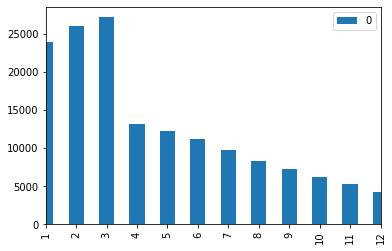

In [160]:
from collections import Counter
import pandas
count = Counter(flat_list_no_of_tuples)
df = pandas.DataFrame.from_dict(count, orient='index')
df.sort_index(inplace=True)
ax= df.plot(kind='bar')
ax.set_xlim(0, 11)


In [162]:
len(flat_list_no_of_tuples)

174932